# Отчет по лабораторной работе 7.1

## Измерение углового распределения жесткой компоненты космического излучения
Конкс Эрик, Б01-818

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import odr
from lmfit.models import LinearModel 

In [2]:
N1 = 1406
N2 = 2182
N_сл = 2 * 10**-7 * N1 * N2
I = [834, 865, 724, 722]
I = [I_i - 532 for I_i in I]
I_err = [1 for _ in range(len(I))]
θ = [0, 20, 40, 45]
θ_err = [20 for _ in range(len(θ))]
lnI = [np.log(i) for i in I]
lnI_err = [I_err[i] / I[i] for i in range(len(I))]
cosθ = [np.cos(np.radians(θ_i)) for θ_i in θ]
ln_cosθ = [np.log(cosθ_i) for cosθ_i in cosθ]
cosθ_err = [np.sin(np.radians(θ[i])) * np.radians(θ_err[i]) for i in range(len(θ))]
ln_cosθ_err = [cosθ_err[i] / cosθ[i] for i in range(len(cosθ))]
ln_cosθ_err[0] = ln_cosθ_err[1]
df = pd.DataFrame({'I': I, 'ΔI': I_err, 'lnI': lnI, 'ΔlnI': lnI_err,
                   'θ': θ, 'Δθ': θ_err, 'ln(cosθ)': ln_cosθ, 'Δln(cosθ)': ln_cosθ_err})
x = ln_cosθ
x_err = ln_cosθ_err
y = lnI
y_err = lnI_err
print(df)
print(f"Nсл = {N_сл}")

     I  ΔI       lnI      ΔlnI   θ  Δθ  ln(cosθ)  Δln(cosθ)
0  302   1  5.710427  0.003311   0  20  0.000000   0.127050
1  333   1  5.808142  0.003003  20  20 -0.062202   0.127050
2  192   1  5.257495  0.005208  40  20 -0.266515   0.292901
3  190   1  5.247024  0.005263  45  20 -0.346574   0.349066
Nсл = 0.6135784


In [3]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [18, 14]

$$I(\theta)=I_0cos^n(\theta)$$

In [4]:
f = lambda p, x: p[0] * x + p[1]
lmodel = LinearModel()
result = lmodel.fit(x, x=y, weights=[1 / x_err[i] for i in range(len(x_err))])
print(result.fit_report())
beta_opt = [0, 0]
beta_err = [0, 0]
beta_opt[0] = 1 / result.best_values['slope']
beta_opt[1] =  - 1 * result.best_values['intercept'] / result.best_values['slope']
beta_err_tmp = np.sqrt(np.diag(result.covar))
beta_err[0] = beta_err_tmp[0] / result.best_values['slope'] * beta_opt[0]
beta_err[1] = -beta_err_tmp[1] / result.best_values['intercept'] * beta_opt[1]
beta_name = ['a', 'b']

print('————————————————————————————————————————————————————————————')

for i in range(len(beta_opt)):
    val = '{:.1f} +- {:.1f}'.format(beta_opt[i], beta_err[i])
    print(f'{beta_name[i]} = {val}')
    
print('\nchisq = {:.2f}'.format(result.chisqr))
print('\na_th = 1.6')

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 4
    # variables        = 2
    chi-square         = 0.40467768
    reduced chi-square = 0.20233884
    Akaike info crit   = -5.16383495
    Bayesian info crit = -6.39124622
[[Variables]]
    slope:      0.45756308 +/- 0.20789975 (45.44%) (init = 1)
    intercept: -2.67143720 +/- 1.18341095 (44.30%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.999
————————————————————————————————————————————————————————————
a = 2.2 +- 1.0
b = 5.8 +- 2.6

chisq = 0.40

a_th = 1.6


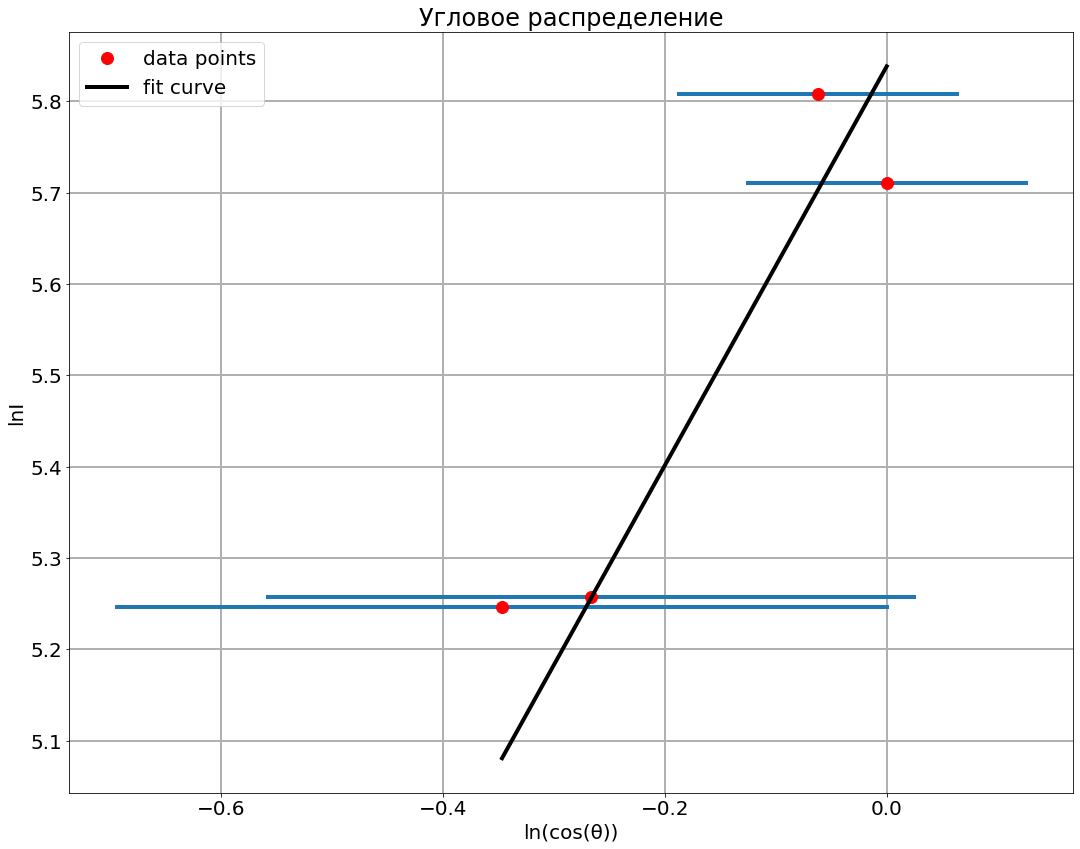

In [5]:
plot = plt.figure(num='Angular distribution')
plt.plot(x, y, 'ro', label='data points', markersize=12)
x_lin = np.linspace(x[-1], x[0], 1000)
plt.plot(x_lin, [f(beta_opt, x) for x in x_lin], color='black', linewidth=4, label='fit curve')
#plt.plot(x, [1.6*x_i + np.log(302) for x_i in x], color='green', linewidth=4, label='expected curve')
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="none", linewidth=4)
plt.grid(linewidth=2)
plt.legend()
plt.title('Угловое распределение')
plt.xlabel('ln(cos(θ))')
plt.ylabel('lnI')
plt.show()

In [6]:
def error(x):
    Δy_b = beta_err[1]
    Δy_a = beta_err[0] * x
    return np.sqrt((Δy_a)**2 + (Δy_b)**2)

Оценим время жизни мюона:

$$\frac{I(\theta)}{I(0)} = (cos\theta)^{1,6}\frac{e^{-L(\theta)\ /\ L}}{e^{-L_0\ /\ L}}$$

$$L(\theta) = \frac{L_0}{cos\theta}$$

$$L_0=15km$$

$$L = \beta c \tau_0 \frac{E_\mu}{m_\mu c^2}$$

$$E_\mu = 4 * 10^9 eV$$

$$m_\mu = 105.8 \ MeV / c^2$$

In [7]:
L0 = 15000
deg = 60
lnI_deg = f(beta_opt, np.log(np.cos(np.radians(deg))))
I_deg_err = error(np.log(np.cos(np.radians(deg))))
lnI0 = f(beta_opt, 0)
I0_err = error(np.log(np.cos(np.radians(0))))
cos = np.cos(np.radians(deg))
E = 4 * 10**9
mc2 = 105.8 * 10**6
c = 3 * 10**8
𝜏0 = ( L0*(cos - 1) ) / ( cos * E * c / mc2 * (lnI_deg - lnI0 - 1.6*np.log(cos)) )
𝜏0_err_1 = 𝜏0 / (lnI_deg) * I_deg_err
𝜏0_err_2 = 𝜏0 / (lnI0) * I0_err
𝜏0_err = np.sqrt(𝜏0_err_1**2 + 𝜏0_err_2**2)
print(f"𝜏0    = {np.round(𝜏0*10**6)} +- {int(np.round(𝜏0_err*10**6))}  10^-6 с")
print(f"𝜏0_th = 2.2       10^-6 с")

𝜏0    = 3.0 +- 2  10^-6 с
𝜏0_th = 2.2       10^-6 с
